### ToDo
- Test if small batch is better
    - Exp 1
        - Save to 006
        - starting from 005, and shring batch size to 512
        - Results: after 183 epochs, the accuracy was actually lower than before training. Batch size is probably not to big at 4096.
    - Exp 2
        - Starting from 012, a 100.000 pm net trained for 1600 epochs at bs 4096
        - Switching to bs 32 created horrible results, network totally failed to perform, lost acc from 0.95 to 0.85 in 17 epochs. Plus, super slow to train
- Test Adam
    - Results
        - 007 Adam, final accuracy 0.939 after 500
        - 005 Adadelta, final accuracy 0.952 after 1000 epochs
        - Adam not performing better than Adadelta
- Test 2x2 and 3x3 filters for performance
    - 2x2 5 layers (005)
    - 3x3 3 layers (003)
    - ~50.000 parameters
    - Results
        - 005 vs 008
        - Same performance after 331 epochs
- Test float16
    - 005 float32
    - 010 float16
    - Results
        - float16 scored lower
        - float16 is 40% longer per epoch (35sec vs 50sec per epoch
        - float32 is the way to go!
- Try Batch Normalization
    - model.add(BatchNormalization())
    - Results:
        - Comparing with 005, no batch norm
        - Saved to 011, with batch norm
        - ~same number of weights...
        - Batch Normalization is performing worse after ~40 epochs
- Try different initial weights
    - keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    - Results
        - Tried for a few epochs, similar curve as for 005
- Test bigger model, try to get it to overfit
    - Experiments
        - 005
            - 50kpm
            - 500 epochs
            - 0.952 acc
            - still learning
        - 013
            - 188kpm
            - 350 epochs
            - 0.968 acc
            - 150-200 epochs > stalled
            - 0.968 after 350 epochs
            - 6 hours
        - 014
            - 388kpm
            - epochs
            - 0.974 after 243 epochs
        - 016
            - 500kpm
            - 143 epochs
            - worse performance than 014, possibly slower to converge, but taking to long to train
    - Results
        - 014 is best, 005 probably good enough
        
- Try smaller batch size
    - Tf from 014 (2048)
    - 015 (256)
    



- early stopping and tensorboard
    - https://keras.io/callbacks/
    - https://stackoverflow.com/questions/43906048/keras-early-stopping
- Add grid lines to plots
    - https://matplotlib.org/api/_as_gen/matplotlib.pyplot.grid.html
- Three fold splitting
    - model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10)
    - https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
- cross validation
    - https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
- Test Checkpoints feature
- Train longer....

- Try opther optimizers

- Make histogram of WDL values
- Test TensorBoard
    - Results
- Do TL experiment
    - Take into account data split effect on TL (split 4pc at x, and then transfer to 5pc)
    - Three split data, training, validation and testing
    - Results
- Finish 5pc dataset



# WDL score count
#### 3PKk-WDL-Seq
[0, 0, 125024, 0, 124960]

In [1]:
##############################
#
#    PARAMETERS 
#
##############################


import math

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Transfer Learning
loadWeights = False 
weightsSource = '012'

# Save results
saveResults = True

# Compare with other result during training
compareResultsDuringTraining = True
compareWith = '005' # orginal net structure, trained from random on 4pc dataset


# NN parameters
useBatchNorm = False
filters = [8,16,32,64,128]
filterShape = [2,2,2,2,2]
batch_size = 4096
epochs = 500
multiGPU = False
whichGPU = 0
# optimizer = 'Adam'
optimizer = 'Adadelta'



### NO NEED TO MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullState'
dataSetWdlName = tableBase + '_Wdl_onlyLegal'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Other NN stuff
num_classes = 5
input_shape = (4,8,8)

##############################
#
#    IMPORTS 
#
##############################

# ### To select which GPU to use, import these before importing Keras or Tensorflow
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either &quot;0&quot; or &quot;1&quot;
# os.environ["CUDA_VISIBLE_DEVICES"]="0"  
 
# # Do other imports now...

import os
    
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)

from matplotlib import pyplot as plt
from IPython.display import clear_output

# from __future__ import print_function
import keras
# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras import backend as K
# import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import h5py
import numpy as np
import pickle

##############################
#
#    Misc Functions
#
##############################

def createDir(dir):
    if os.path.exists(dir):
        print("Error, directory " + str(dir) + " already exists, abort mission.")
        sys.exit()
    else:
        os.makedirs(dir)
        
def save_obj(saveDir, saveName, obj ):
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)
    with open(saveDir + '/' + saveName + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(dir, fileName ):
    with open(dir + '/' + fileName + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# compareResultsDuringTraining = True
# compareWith = '005'

class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        # Reshape input vector to fit on graph
        def reshapeVector(vec):
            l = len(vec)
            L = epochs - l
            if L>=0:
                tail = np.ones((L), dtype = int) * vec[-1]
                vec = np.hstack((vec,tail))
            return vec
                
        
        # Load data to compare with 
        if compareResultsDuringTraining:
            self.compareData = load_obj('Results/' + compareWith, 'fitHistory')
            self.compAcc = reshapeVector(self.compareData['acc'])
            self.compValAcc = reshapeVector(self.compareData['val_acc'])
            self.compLoss = reshapeVector(self.compareData['loss'])
            self.compValLoss = reshapeVector(self.compareData['val_loss'])
        
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
    
        # Plot Loss
        plt.figure(figsize=(8,8))
        plt.plot(self.x, self.losses, 'b-', label="Train", linewidth = 1)
        plt.plot(self.x, self.val_losses, 'r-', label="Validation", linewidth = 1)
        plt.plot(self.x, self.compLoss[:len(self.losses)], 'b--', label=compareWith + " Training")
        plt.plot(self.x, self.compValLoss[:len(self.losses)], 'r--', label=compareWith + " Validation")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.ylim(bottom=0)
        plt.grid(True)
        plt.savefig('fitTemp/currentLoss')
        plt.show();
        
        # Plot Accuracy
        plt.figure(figsize=(8,8))
        plt.plot(self.x, self.accuracy, 'b-', label="Train", linewidth = 1)
        plt.plot(self.x, self.val_accuracy, 'r-', label="Validation", linewidth = 1)
        plt.plot(self.x, self.compAcc[:len(self.accuracy)], 'b--', label=compareWith + " Training")
        plt.plot(self.x, self.compValAcc[:len(self.accuracy)], 'r--', label=compareWith + " Validation")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracty')
        plt.legend()
        plt.ylim(top=1)
        plt.grid(True)
        plt.savefig('fitTemp/currentAcc')
        plt.show();
        
        print("Train Accuracy of last epoch: ", logs['acc'])
        print("Validation Accuracy of last epoch: ", logs['val_acc'])
        print("Train Loss of last epoch: ", logs['loss'])
        print("Validation Loss of last epoch: ", logs['val_loss'])
        
        with open('fitTemp/logs.txt','w') as file:
            file.write(str(logs))
            
        with open('fitTemp/atEpochNr.txt','w') as file:
            file.write(str(epoch))
        
plot_losses = PlotLosses()

def sq2hnit(sq):
    col = sq%8
    row = (sq - col)//8
    return col,row

# 0: pawns
# 1: kings
def vecSt2fullSt(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((4,8,8), dtype = 'bool')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[0][row][col] = True
        else:
            fullSt[1][row][col] = True
    col,row = sq2hnit(vecSt[-2])
    fullSt[2][row][col] = True
    col,row = sq2hnit(vecSt[-1])
    fullSt[3][row][col] = True
    return fullSt 

def vecSt2fullSt_8x8x2(vecSt, nPi, nPa, nWPa):
    fullSt = np.zeros((8,8,2), dtype = 'int8')
    for i in range(nPi - 2):
        sq = vecSt[i]
        col,row = sq2hnit(sq)
        if i < nWPa:
            fullSt[row][col][0] = 1
        else:
            fullSt[row][col][0] = -1
    col,row = sq2hnit(vecSt[-2])
    fullSt[row][col][1] = 1
    col,row = sq2hnit(vecSt[-1])
    fullSt[row][col][1] = -1
    return fullSt 

# count nr of each score instance
# wdlCounter placeholders: [-2, -1, 0, 1 ,2]

def wdlCountingMachine(ds):
    wdlCounter = [0,0,0,0,0]
    l = len(ds)
    i = 0
    intv = l//100
    for wdl in ds:
        i += 1
        if i%intv == 0:
            sys.stdout.write(str((i*100)//l) + " percentage")
            sys.stdout.write('\r')
            sys.stdout.flush()
        wdlCounter[wdl[0] + 2] += 1
    print(wdlCounter)
    return wdlCounter
# wdlCountingMachine(d3t)

##############################
#
#    LOAD DATA
#
##############################
# load datasets
def loadData():
    with h5py.File(fileName, 'r') as f:
        d = f[dataSetName]
        dt = f[dataSetWdlName]
        l = len(d)
        loadLength = int(l * fractionOfDataToUse)

        if convertStates:
            X = np.array([vecSt2fullSt(vecSt,nPi, nPa, nWPa) for vecSt in d[:loadLength]])
        else:
            X = d[:loadLength]

        y = dt[:loadLength]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    del X
    del y

    print('X_train shape:', X_train.shape)
    print('y_train shape:', y_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_test shape:', y_test.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')


    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = loadData()

##############################
#
#    CREATE MODEL
#
##############################
def createModel(filters, filterShape):
    # import keras.backend as K
    # K.set_floatx('float16')
    # K.set_epsilon(1e-4) #default is 1e-7
    # K.set_floatx('float32')
    # K.set_epsilon(1e-7) #default is 1e-7

    model = Sequential()


    nnStr = ''
    for i in range(len(filters)):
        s = str(filterShape[i])
        filter = str(filters[i])
        nnStr += s + 'x' + filter + '-'
    nnStr = nnStr[:-1]

    assert (len(filters) == len(filterShape)),"Error, len(filters) != len(filterShape)"
    if useBatchNorm:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 data_format = "channels_first",
                                 use_bias = False,
                #                  kernel_initializer = 
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 use_bias = False,
                                 padding='valid'))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
    else:
        for i in range(len(filters)):
            if i  == 0:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
                                 activation='relu',
                                 data_format = "channels_first",
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 input_shape=input_shape))
            else:
                model.add(Conv2D(filters[i], kernel_size=(filterShape[i], filterShape[i]),
                                 padding='valid',
    #                              kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None),
                                 activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    if multiGPU: 
        model = keras.utils.multi_gpu_model(model, gpus=2)
    model.summary()
    
    if loadWeights:
        model.load_weights('Results/' + weightsSource + '/weights.hdf5')


    if optimizer == "Adadelta":
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                      metrics=['accuracy'])
    else:
        sys.exit("Error, invalid optimizer.")
    return model, nnStr

#filters = [8,32,64,128,256]
#filterShape = [2,2,2,2,2]
#model = createModel(filters, filterShape)

##############################
#
#    TRAIN MODEL
#
##############################
def trainModel():
    fitHistory = model.fit(X_train, y_train,
          batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[plot_losses],
              validation_data=(X_test, y_test))
    return fitHistory
#fitHistory = trainModel()

##############################
#
#    CALCULATE SCORE
#
##############################
def calcScore():
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Evaluated test loss:', score[0])
    print('Evaluated test accuracy:', score[1])
    return score
#score = calcScore()

##############################
#
#    SAVE RESULTS
#
##############################
def saveTrainResults():
    #Get next fitID
    with open('Results/lastFitId.txt','r') as file:
        lastId = file.read()
    fitId = str(int(lastId) + 1).zfill(3)
    fitId = fitId
    with open('Results/lastFitId.txt','w') as file:
        file.write(fitId)

    # Generate save dir
    saveDir = 'Results/' + str(fitId)
    print('Save dir: ' + saveDir)
    print("Creating save dir")
    if os.path.exists(saveDir):
        print("Save dir already exists, aborting!!!")
        sys.exit("Save dir already exists, aborting!!!")

    # Save info directories
    ep = len(model.history.history['acc'])
    if loadWeights:
        initWeightsId = weightsSource
    else:
        initWeightsId = 'RND'
    createDir(saveDir + '/_' +  '1.numberOfPieces-------' + str(nPi)) 
    createDir(saveDir + '/_' +  '2.neuralNetStructure---' + str(nnStr) )
    createDir(saveDir + '/_' +  '3.loadedWeightsFrom----' +  str(initWeightsId) )
    createDir(saveDir + '/_' +  '4.epochs---------------' +  str(ep) + '_of_' + str(epochs) )
    createDir(saveDir + '/_' +  '5.batchSize------------' +  str(batch_size) )
    createDir(saveDir + '/_' +  '6.optimizer------------' +  str(optimizer) )
    createDir(saveDir + '/_' +  '7.finalAccuracy--------' +  str(round(score[1],3)))

    #save history
    print("Saving history...")
    hist = model.history.history
    saveName = 'fitHistory'
    save_obj(saveDir, saveName, hist)

    #save weights
    print("Saving weights...")
    model.save_weights(saveDir + '/' + 'weights.hdf5')

    #save figures
    print("Saving figures...")
    acc = hist['acc']
    loss = hist['loss']
    val_acc = hist['val_acc']
    val_loss = hist['val_loss']
    x = [i for i in range(len(acc))]

    plt.plot(x,loss, label = "Loss")
    plt.plot(x,val_loss, label = "Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(saveDir + '/loss')
    plt.show()

    plt.plot(x,acc, label = "Accuracy")
    plt.plot(x,val_acc, label = "Validation Acc")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(saveDir + '/acc')
    plt.show()

    #save summary
    print("Saving summary...")
    from contextlib import redirect_stdout

    with open(saveDir + '/modelsummary.txt', 'w') as f:
        with redirect_stdout(f):
            model.summary()
    print("All done!")
#saveTrainResults()

##############################
#
#    COMPARE RESULTS
#
##############################
def compareResults(res1, res2, label1 = '', label2 = '', metric1 = 'acc', metric2 = 'acc', saveFigName = '', makeEqual = False):
    # Reshape input vector to fit on graph
    def makeEqualLength(vec1, vec2):
        l1 = len(vec1)
        l2 = len(vec2)
        if l1 == l2:
             pass
        elif l1 > l2: 
            l = l1 - l2
            tail = np.ones((l), dtype = int) * vec2[-1]
            vec2 = np.hstack((vec2,tail))
        else:
            l = l2 - l1
            tail = np.ones((l), dtype = int) * vec1[-1]
            vec1 = np.hstack((vec1,tail))
        return vec1, vec2
     
    y1 = load_obj('Results/' + res1,'fitHistory')
    y2 = load_obj('Results/' + res2,'fitHistory')
    acc1 = y1[metric1]
    acc2 = y2[metric2]
    
    if makeEqual:
        acc1, acc2 = makeEqualLength(acc1, acc2)
    
    if label1 == '' :
        label1 = res1
    if label2 == '' :
        label2 = res2
        
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    
    x = [i for i in range(len(acc1))]
    plt.plot(x,acc1, label = label1)
    x = [i for i in range(len(acc2))]
    plt.plot(x,acc2, label = label2)
    bottom, top = plt.ylim()  # return the current ylim
    if "acc" in metric1:
        print('plotting accuracy')
        yname = "Accuracy"
        plt.ylim(bottom = bottom, top=1)
    else:
        print('plotting loss')
        plt.ylim(bottom = 0, top=top)
        yname = "Loss"
    plt.xlabel('epochs')
    plt.ylabel(yname)
    plt.legend()
    if saveFigName != '': plt.savefig(saveFigName)
    plt.show()

#compareResults('005','011', label1='test1', label2='test2', metric1='loss', metric2='loss', saveFigName = 'testmynd', makeEqual = True)

Using TensorFlow backend.


### Try 388.000 weights and larger batch size


In [21]:
import math

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Transfer Learning
loadWeights = False 
weightsSource = '014'

# Compare with other result during training
compareResultsDuringTraining = True
compareWith = '014' # orginal net structure, trained from random on 4pc dataset


# NN parameters
# filters = [32,64,128,160,256]
filters = [32,64,128,256,256]
filterShape = [2,2,2,2,2]
batch_size = 2048
epochs = 350 

In [11]:
X_train, X_test, y_train, y_test = loadData()

X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples


In [22]:
model, nnStr = createModel(filters, filterShape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 7, 7)          544       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 31, 6, 64)         1856      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 30, 5, 128)        32896     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 4, 256)        131328    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 3, 256)        262400    
_________________________________________________________________
flatten_6 (Flatten)          (None, 21504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 107525    
Total para

In [ ]:
fitHistory = trainModel()

Train on 4982178 samples, validate on 2453910 samples
Epoch 1/350
 147456/4982178 [..............................] - ETA: 4:26 - loss: 1.0124 - acc: 0.4985

In [24]:
    score = calcScore()

2453910/2453910 [==============================] - 141s 57us/step
Evaluated test loss: 0.0986486749706243
Evaluated test accuracy: 0.9720201637385407


Save dir: Results/014
Creating save dir
Saving history...
Saving weights...
Saving figures...


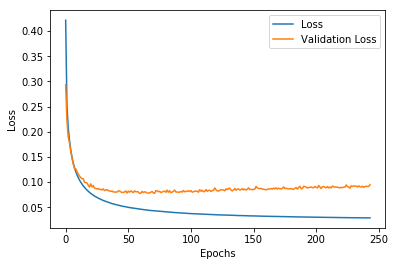

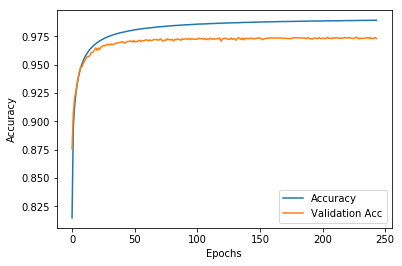

Saving summary...
All done!


In [13]:
saveTrainResults()

plotting accuracy
plotting accuracy


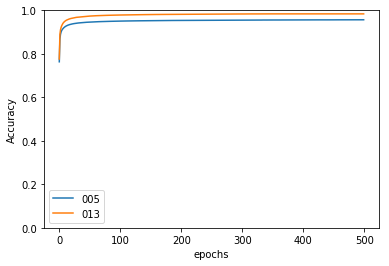

plotting accuracy
plotting accuracy


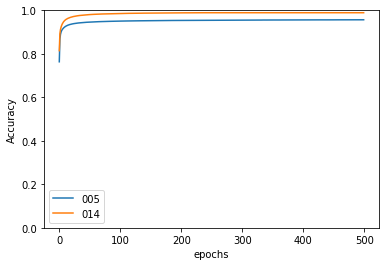

plotting accuracy
plotting accuracy


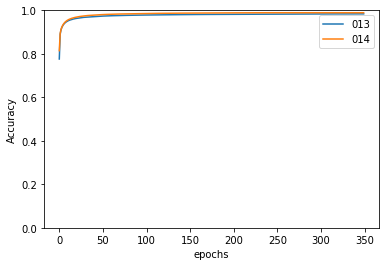

In [17]:
compareResults('005','013', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)
compareResults('005','014', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)
compareResults('013','014', metric1='acc', metric2='acc', saveFigName = 'testmynd', makeEqual = True)

# take sample from 5, and gen wdls

In [ ]:
sys.exit()
import h5py
# f.close()
fs.close()
fd.close()
# ft.close()
fs = h5py.File('AllStates_intVec.hdf5', 'r')
# fd = h5py.File('5PPpKk.hdf5', 'w')
fd = h5py.File('5PPpKk.hdf5', 'a')

# fs.copy('5PPpKk', fd['/'])
fdn = list(fd)
print(fdn)

x = fd[fdn[0]]

    

lFull = len(x)
print(lFull)
lPart = 500000
# lPart = lFull//1000
# print(lPart)
# fd.create_dataset('5PPpKk_random500k', shape=(500000,5))
dd = fd['5PPpKk_random500k']

# import sys
# sys.exit()

In [ ]:
sys.exit()
from random import randint
for i in range(500):
    r = randint(0,lFull - 1000)
    xPart = x[r:r+1000]
    dd[i*1000:i*1000+1000] = xPart 
    
# f = h5py.File('5PPpKk_TlTest.hdf5', 'a')
# fn = list(f)
# fn
# f.create_dataset('5PPpKk_0.01')


### copy dataset

In [ ]:
sys.exit()
fd.close()
with h5py.File('5PPpKk.hdf5', 'a') as fs:
    fsn = list(fs)
    print(fsn)
    ds = fs[fsn[1]]
    
    with h5py.File('5PPpKk_random500k.hdf5', 'w') as fd:
        fs.copy(fsn[1], fd['/'])
        fdn = list(fd)
        print(fdn)
